In [1]:
import os
import sys

import xarray as xr
import numpy as np
import zarr

import pandas as pd

import s3fs
import gcsfs
import boto3



import matplotlib
import matplotlib.pyplot as plt

import itertools
from functools import partial

from dask.distributed import Client

import cartopy.crs as ccrs
import cartopy.feature as cf

GCP_PROJECT_ID = '170771369993'
OISST_GCP = 'oisst/oisst.zarr'

%matplotlib inline

In [2]:
dask_client = Client()
dask_client

Client Scheduler: tcp://127.0.0.1:36651 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 8 Memory: 33.45 GB


# Compute TPC across regions

In [3]:
# Load SST
fs = gcsfs.GCSFileSystem(project=GCP_PROJECT_ID, token="../gc-pangeo.json")
oisst = xr.open_zarr(fs.get_mapper(OISST_GCP))
oisst = oisst.assign_coords(lon=(((oisst.lon + 180) % 360) - 180)).sortby('lon')
# Slice to PNW
PNW_LAT = slice(30, 60)
PNW_LON = slice(-155.9, -120.9)
oisst_pnw = oisst.sel(lat = PNW_LAT, lon = PNW_LON).compute()
# Load MHWs
awsfs = s3fs.S3FileSystem()
mhw_mapper = s3fs.S3Map("s3://mhw-stress/new_with_climatology", s3=awsfs)
mhws = xr.open_zarr(mhw_mapper, consolidated=True)

In [4]:
mhws = xr.open_zarr(mhw_mapper, consolidated=True)
mhws = mhws.chunk({
    'lat': 100, 
    'lon' : 100, 
    'time': 500
})

In [5]:
mhws.mhw.data

,Array,Chunk
Bytes,1.83 GB,40.00 MB
Shape,"(120, 140, 13636)","(100, 100, 500)"
Count,871 Tasks,112 Chunks
Type,float64,numpy.ndarray


## Choose a Region

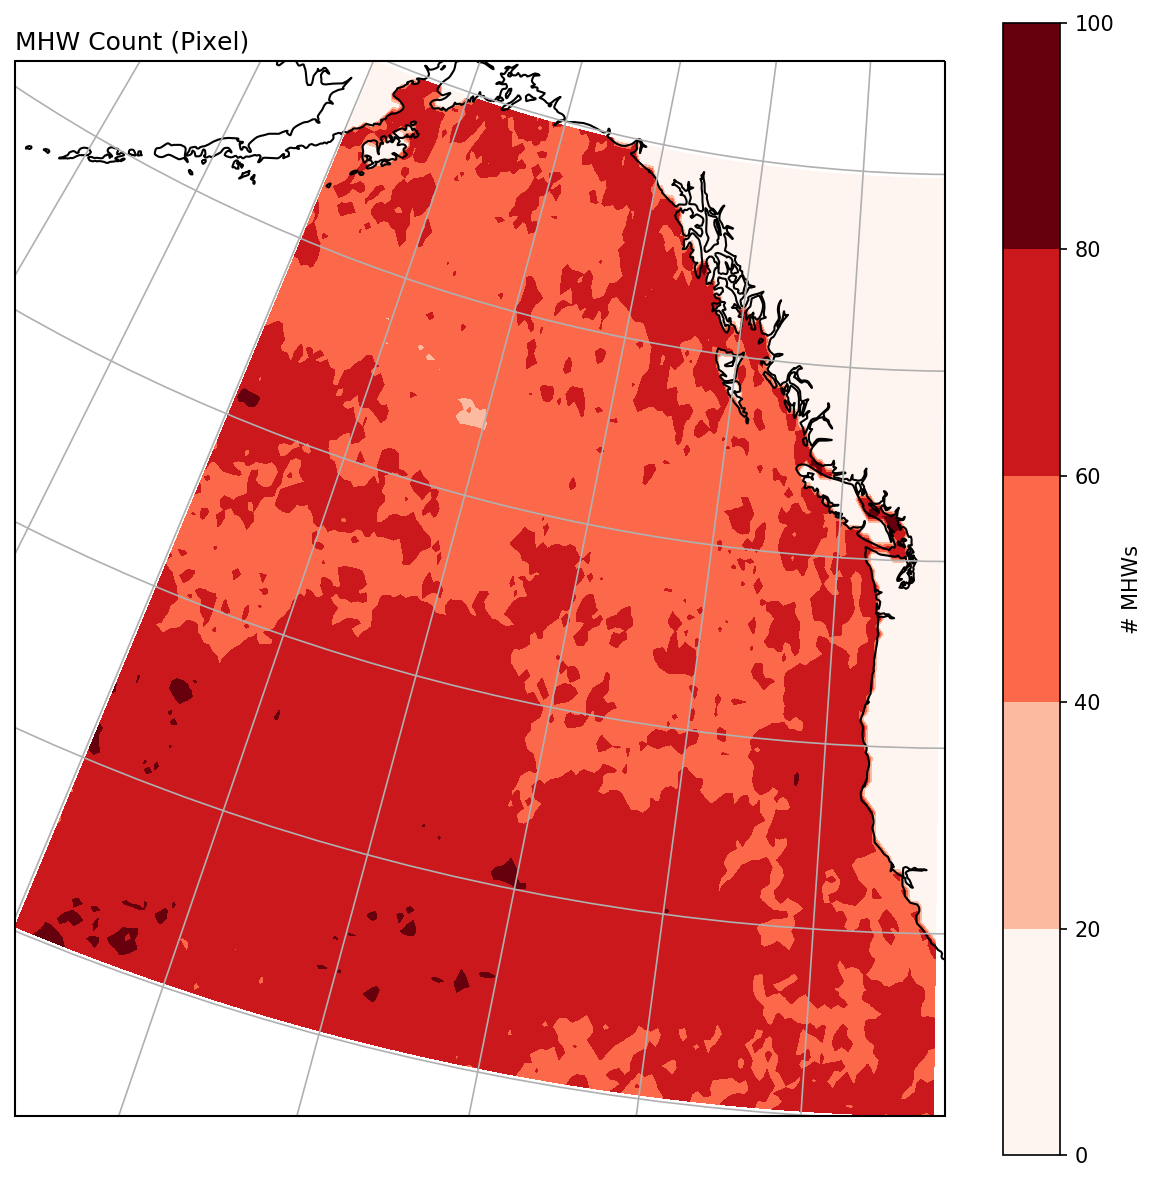

In [20]:
fig = plt.figure(figsize=(10,10), dpi=150)
ax = plt.axes(projection=ccrs.LambertConformal(central_longitude=-120))
mhws.mhw.max(dim='time').plot.contourf(
    ax=ax, transform=ccrs.PlateCarree(),
    cbar_kwargs={'label' : "# MHWs"},
    cmap=plt.cm.Reds
)
ax.add_feature(cf.NaturalEarthFeature('physical', 'coastline', '50m'), facecolor='none', edgecolor='k')
ax.set_title("MHW Count (Pixel)", loc='left')
ax.gridlines()

## MHWs/year Recently

In [11]:
mhws = mhws.persist()

In [24]:
decade = mhws.sel(time=slice('1980', '1990'))

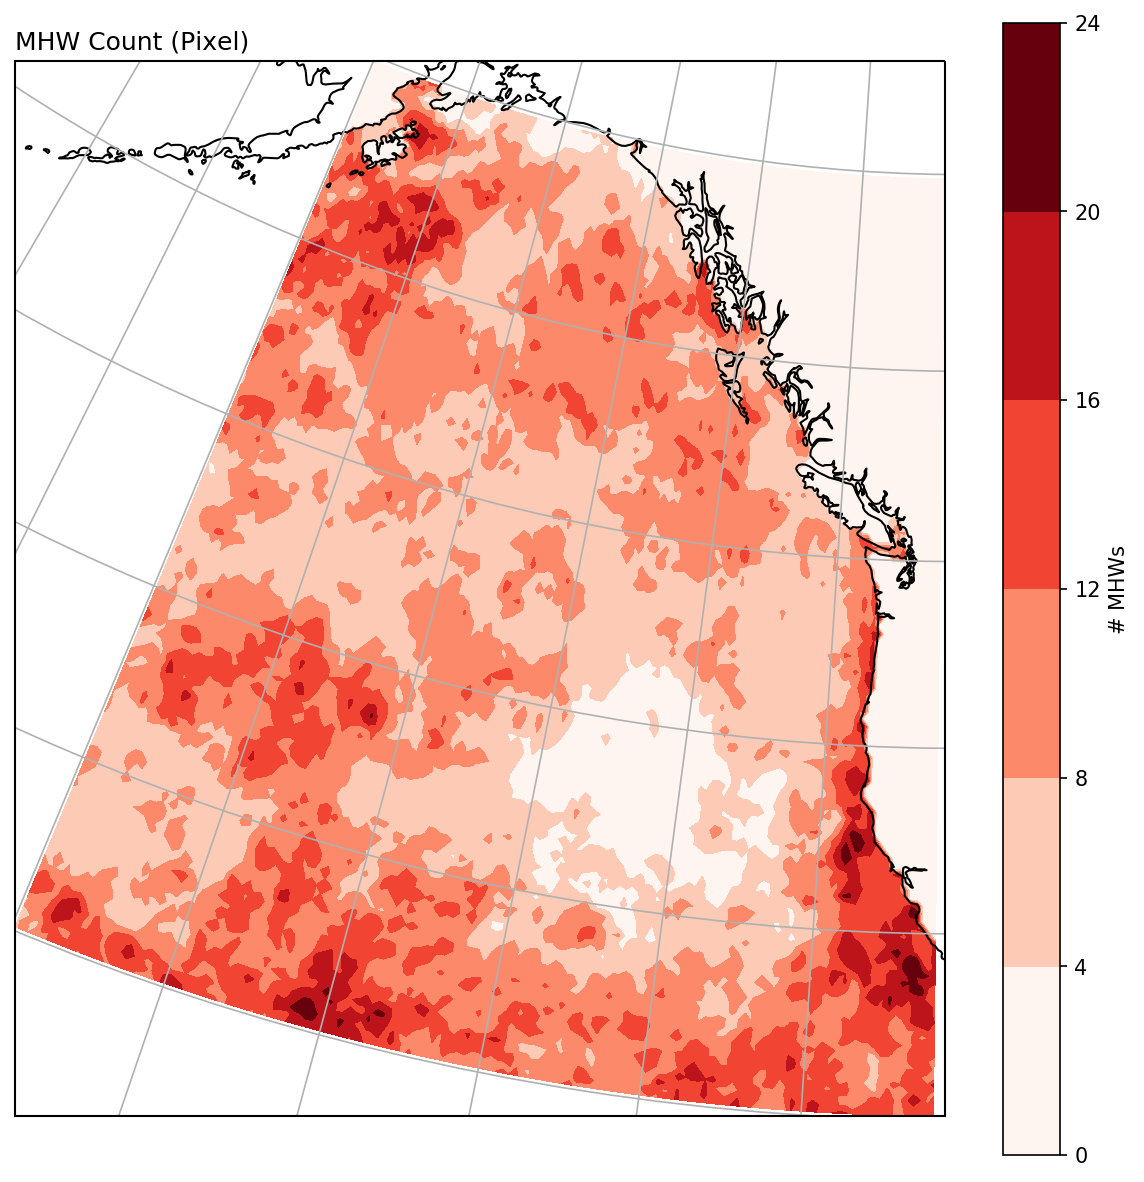

In [26]:
fig = plt.figure(figsize=(10,10), dpi=150)
ax = plt.axes(projection=ccrs.LambertConformal(central_longitude=-120))
decade.mhw.max(dim='time').plot.contourf(
    ax=ax, transform=ccrs.PlateCarree(),
    cbar_kwargs={'label' : "# MHWs"},
    cmap=plt.cm.Reds
)
ax.add_feature(cf.NaturalEarthFeature('physical', 'coastline', '50m'), facecolor='none', edgecolor='k')
ax.set_title("MHW Count (Pixel)", loc='left')
ax.gridlines()

In [81]:
masked = mhws.where(mhws.mhw !=0).sel(time=slice('1990', '2016')).mhw.groupby('time.year').count(dim='time')

In [78]:
a = masked.compute()

In [118]:
extent = [
    oisst_pnw.lon.min().values,
    oisst_pnw.lon.max().values,
    oisst_pnw.lat.min().values,
    oisst_pnw.lat.max().values

]

In [116]:
help(fg.axes.ravel()[0].set_extent)

Help on method set_extent in module cartopy.mpl.geoaxes:

set_extent(extents, crs=None) method of cartopy.mpl.geoaxes.GeoAxesSubplot instance
    Set the extent (x0, x1, y0, y1) of the map in the given
    coordinate system.
    
    If no crs is given, the extents' coordinate system will be assumed
    to be the Geodetic version of this axes' projection.
    
    Parameters
    ----------
    extent
        Tuple of floats representing the required extent (x0, x1, y0, y1).



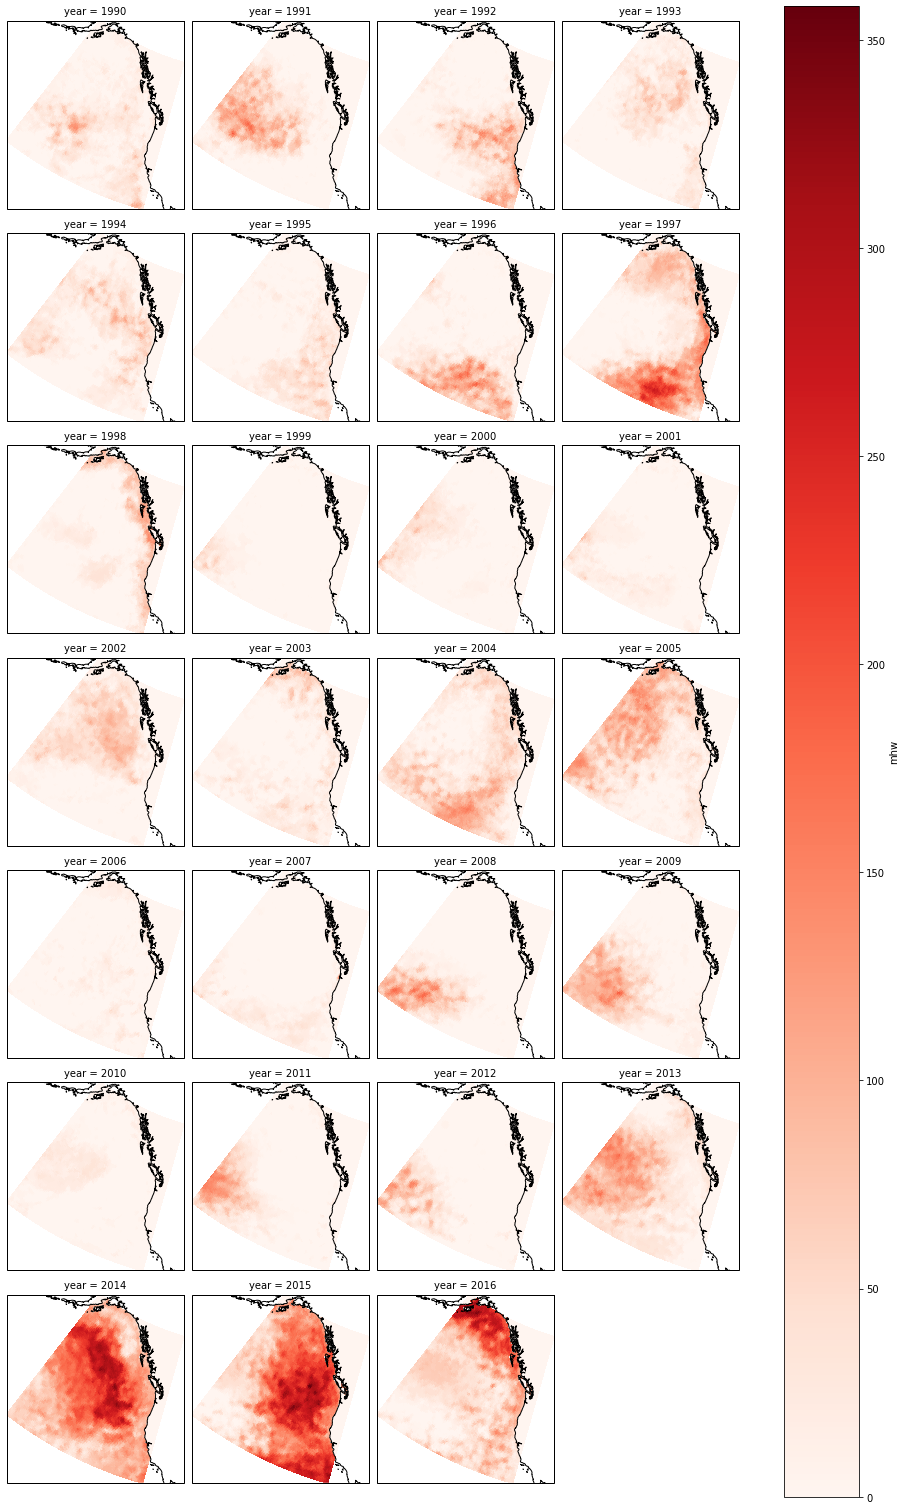

In [80]:
fg = a.plot.pcolormesh(col='year', col_wrap = 4, transform=ccrs.PlateCarree(), cmap='Reds', subplot_kws={'projection': ccrs.LambertConformal()})

list(map(lambda x: x.set_extent(extent), fg.axes.ravel()))
list(map(lambda x: x.add_feature(cf.NaturalEarthFeature('physical', 'coastline', '50m'), facecolor='none', edgecolor='k'), fg.axes.ravel()))

## TPCs?


In [101]:
sys.path.append('../analysis/physiology/')
import tpc

In [94]:
plankton = pd.read_csv('../data/Phytoplankton_temperature_growth_rate_dataset_2016_01_29/traits_derived_2016_01_29.csv', engine='python')

In [95]:
plankton = plankton[
    (plankton.curvequal == 'good') &
    (plankton.habitat.isin([
        'marine',
    ]))
]
len(plankton)

96

In [71]:
# plankton['latqbin'] = pd.qcut(plankton['isolation.latitude'], q=5)
# plankton = plankton[plankton.latqbin.isin([mhws.lat.values.max()])]

In [98]:
sample = plankton.sample(1).iloc[0]

In [99]:
sample

isolate.code                                            171
source                               Monterrey Bay, CA, USA
isolation.latitude                                    36.61
isolation.longitude                                 -121.89
habitat                                              marine
name                                    Prorocentrum micans
speciesname                             Prorocentrum micans
former.name.1                                           NaN
former.name.2                                           NaN
strain                                                  NaN
clone                                                   NaN
species                                              micans
genus                                          Prorocentrum
family                                      Prorocentraceae
order                                        Prorocentrales
class                                           Dinophyceae
phylum                                  

In [102]:
median_tpc = partial(tpc.tpc, a=sample['mu.alist'], b=sample['mu.blist'], z=sample['mu.c.opt.list'], w=sample['mu.wlist'])

In [107]:
def tpc_1d(temps):
    if(np.isnan(temps).any()): return np.full_like(temps, fill_value=np.nan)
    return(median_tpc(temps))
    


In [104]:
tpc = xr.apply_ufunc(
    tpc_1d,
    oisst_pnw.sst.chunk({'lat': 5, 'lon': 5, 'time': -1}),
    input_core_dims=[['time']],
    output_core_dims = [['time']],
    dask='parallelized', 
    output_dtypes=['float64'],
    vectorize=True
)

In [105]:
tpc

,Array,Chunk
Bytes,1.83 GB,2.73 MB
Shape,"(120, 140, 13636)","(5, 5, 13636)"
Count,2017 Tasks,672 Chunks
Type,float64,numpy.ndarray


In [106]:
ans = tpc.compute()

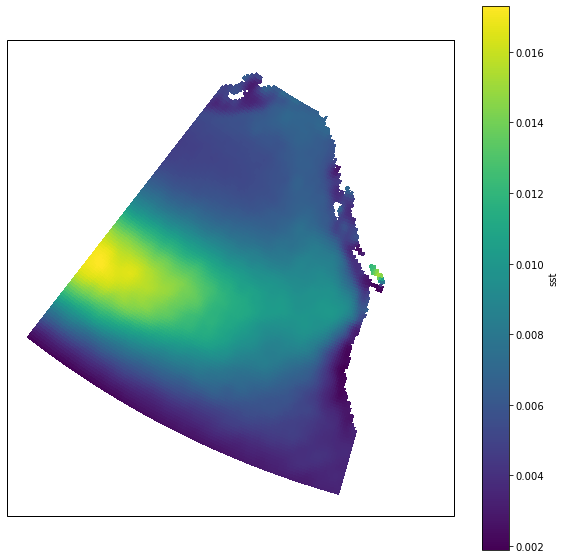

In [108]:
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.LambertConformal())
ans.var(dim='time').plot(transform=ccrs.PlateCarree(), ax=ax)

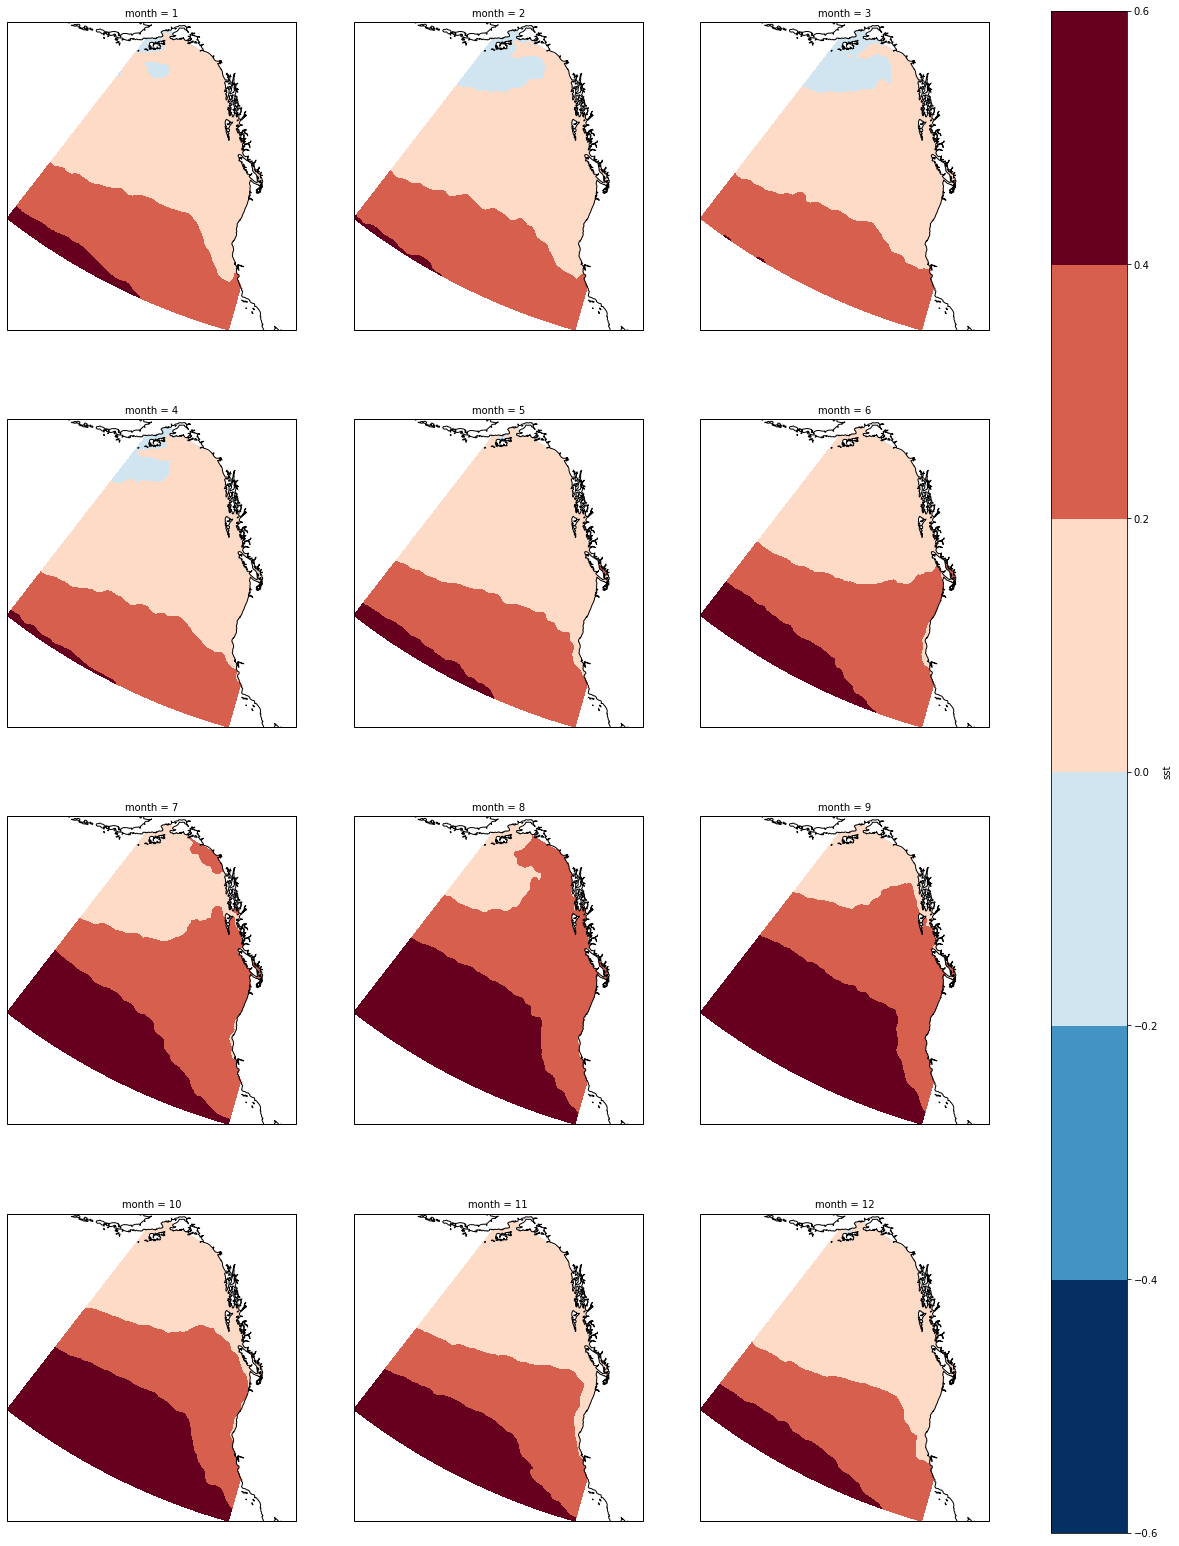

In [125]:


fg = ans.sel(time=slice('1990', '1995')).groupby('time.month').mean(dim='time').plot.contourf(size=7,col='month', col_wrap=3, transform=ccrs.PlateCarree(), subplot_kws={'projection': ccrs.LambertConformal()}, )
list(map(lambda x: x.set_extent(extent), fg.axes.ravel()))
list(map(lambda x: x.add_feature(cf.NaturalEarthFeature('physical', 'coastline', '50m'), facecolor='none', edgecolor='k'), fg.axes.ravel()))